In [4]:
# Imports and settings

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import pickle
import os

print("Imports complete. Python version:", pd.__version__)


Imports complete. Python version: 2.3.1


In [5]:
# Load dataset and show top rows + info

csv_path = "adspend.csv"  # make sure the file is in the same folder as your notebook
df = pd.read_csv(csv_path)
print(f"Loaded data from: {csv_path} — shape: {df.shape}\n")

print("\nTop 5 rows:")
print(df.head())

print("\nDataFrame info:")
print(df.info())

print("\nSummary statistics:")
print(df.describe(include='all').transpose())


Loaded data from: adspend.csv — shape: (2115, 7)


Top 5 rows:
         date  shown  clicked  converted  avg_cost_per_click  total_revenue  \
0  2015-10-01  65877     2339         43                0.90         641.62   
1  2015-10-02  65100     2498         38                0.94         756.37   
2  2015-10-03  70658     2313         49                0.86         970.90   
3  2015-10-04  69809     2833         51                1.01         907.39   
4  2015-10-05  68186     2696         41                1.00         879.45   

           ad  
0  ad_group_1  
1  ad_group_1  
2  ad_group_1  
3  ad_group_1  
4  ad_group_1  

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2115 entries, 0 to 2114
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                2115 non-null   object 
 1   shown               2115 non-null   int64  
 2   clicked             2115 non-null   int64 

In [6]:
# Preprocessing - create features (CTR, conversion rate), encode categorical 'ad', drop date

df2 = df.copy()
df2['date'] = pd.to_datetime(df2['date'], errors='coerce')

# Create CTR and conversion_rate
df2['ctr'] = np.where(df2['shown'] > 0, df2['clicked'] / df2['shown'], 0.0)
df2['conv_rate'] = np.where(df2['clicked'] > 0, df2['converted'] / df2['clicked'], 0.0)

# One-hot encode 'ad' column
df2 = pd.get_dummies(df2, columns=['ad'], drop_first=True)

# Drop missing values (if any)
df2 = df2.dropna(subset=['total_revenue'])

# Prepare features and target
feature_cols = ['shown', 'clicked', 'converted', 'avg_cost_per_click', 'ctr', 'conv_rate'] + \
               [c for c in df2.columns if c.startswith('ad_')]
X = df2[feature_cols]
y = df2['total_revenue']

print("Feature columns:", feature_cols)
print("X shape:", X.shape, "y shape:", y.shape)
print(X.head())


Feature columns: ['shown', 'clicked', 'converted', 'avg_cost_per_click', 'ctr', 'conv_rate', 'ad_ad_group_10', 'ad_ad_group_11', 'ad_ad_group_12', 'ad_ad_group_13', 'ad_ad_group_14', 'ad_ad_group_15', 'ad_ad_group_16', 'ad_ad_group_17', 'ad_ad_group_18', 'ad_ad_group_19', 'ad_ad_group_2', 'ad_ad_group_20', 'ad_ad_group_21', 'ad_ad_group_22', 'ad_ad_group_23', 'ad_ad_group_24', 'ad_ad_group_25', 'ad_ad_group_26', 'ad_ad_group_27', 'ad_ad_group_28', 'ad_ad_group_29', 'ad_ad_group_3', 'ad_ad_group_30', 'ad_ad_group_31', 'ad_ad_group_32', 'ad_ad_group_33', 'ad_ad_group_34', 'ad_ad_group_35', 'ad_ad_group_36', 'ad_ad_group_37', 'ad_ad_group_38', 'ad_ad_group_39', 'ad_ad_group_4', 'ad_ad_group_40', 'ad_ad_group_5', 'ad_ad_group_6', 'ad_ad_group_7', 'ad_ad_group_8', 'ad_ad_group_9']
X shape: (2115, 45) y shape: (2115,)
   shown  clicked  converted  avg_cost_per_click       ctr  conv_rate  \
0  65877     2339         43                0.90  0.035506   0.018384   
1  65100     2498         38  

In [10]:
# Train/test split and Linear Regression training

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Compute metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

metrics = {
    "train_r2": train_r2,
    "test_r2": test_r2,
    "train_accuracy(%)": train_r2 * 100,
    "test_accuracy(%)": test_r2 * 100,
    "train_mse": mean_squared_error(y_train, y_train_pred),
    "test_mse": mean_squared_error(y_test, y_test_pred),
    "train_mae": mean_absolute_error(y_train, y_train_pred),
    "test_mae": mean_absolute_error(y_test, y_test_pred)
}

print("Training and evaluation complete. Metrics:")
for k, v in metrics.items():
    if "accuracy" in k:
        print(f"{k}: {v:.2f}%")
    else:
        print(f"{k}: {v:.4f}")

# Coefficients table
coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coefficient": lr.coef_
}).assign(abs_coef=lambda d: d['coefficient'].abs()).sort_values('abs_coef', ascending=False)

print("\nTop 10 most influential features:")
print(coef_df.head(10))


Training and evaluation complete. Metrics:
train_r2: 0.8851
test_r2: 0.8385
train_accuracy(%): 88.51%
test_accuracy(%): 83.85%
train_mse: 1934341.0392
test_mse: 1662580.4042
train_mae: 503.2992
test_mae: 484.9986

Top 10 most influential features:
           feature  coefficient     abs_coef
4              ctr -1659.311160  1659.311160
27   ad_ad_group_3   650.008416   650.008416
38   ad_ad_group_4  -450.492763   450.492763
29  ad_ad_group_31  -446.566709   446.566709
22  ad_ad_group_25  -394.508575   394.508575
32  ad_ad_group_34  -323.639518   323.639518
13  ad_ad_group_17  -322.666167   322.666167
42   ad_ad_group_7   301.663757   301.663757
44   ad_ad_group_9  -292.451600   292.451600
35  ad_ad_group_37  -287.919980   287.919980


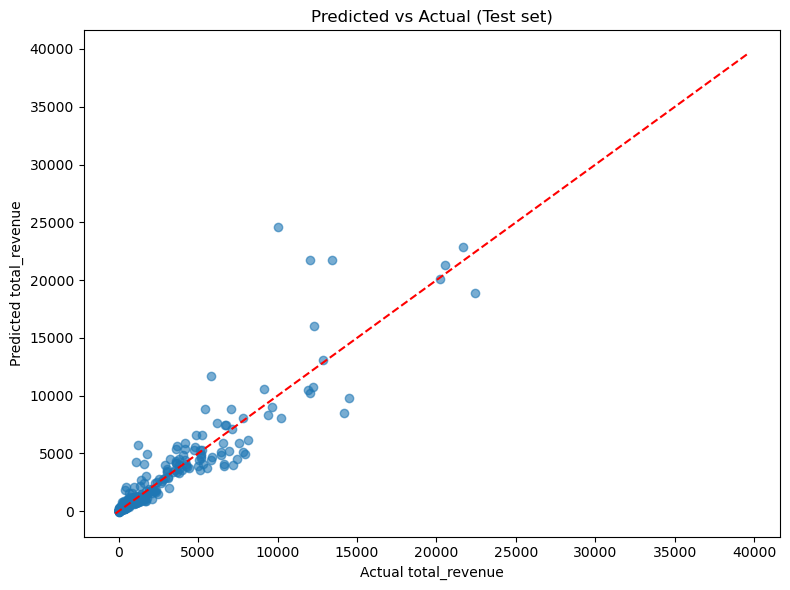

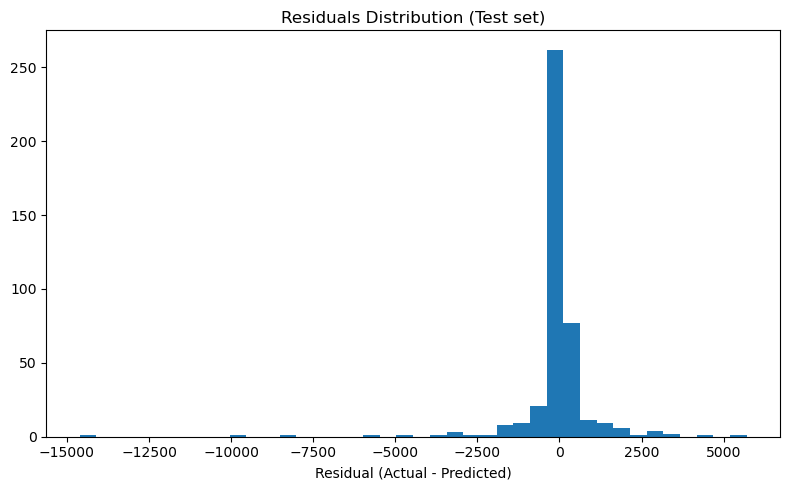

In [8]:
# Plots - Predicted vs Actual and Residuals

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual total_revenue")
plt.ylabel("Predicted total_revenue")
plt.title("Predicted vs Actual (Test set)")
plt.tight_layout()
plt.show()

residuals = y_test - y_test_pred
plt.figure(figsize=(8,5))
plt.hist(residuals, bins=40)
plt.xlabel("Residual (Actual - Predicted)")
plt.title("Residuals Distribution (Test set)")
plt.tight_layout()
plt.show()


In [9]:
# Save trained model to pickle file

model_path = "linear_model_adspend.pkl"
with open(model_path, "wb") as f:
    pickle.dump({
        "model": lr,
        "features": feature_cols,
        "metrics": metrics,
        "coef_table": coef_df
    }, f)

print("Saved trained Linear Regression model to:", model_path)

# Example prediction
sample = pd.DataFrame([X.mean().to_dict()])
print("Example prediction using mean feature values:", lr.predict(sample)[0])


Saved trained Linear Regression model to: linear_model_adspend.pkl
Example prediction using mean feature values: 1979.4402680821217
